# Get Started (GPU memory eco version)

Last update: December 9th (2024) Hajime Kawahara 

This is a GPU memory friendly version of "get started"!  
First, we recommend 64-bit if you do not think about numerical errors. Use jax.config to set 64-bit. 
(But note that 32-bit is sufficient in most cases. Consider to use 32-bit (faster, less device memory) for your real use case.) 

In [1]:
from jax import config
config.update("jax_enable_x64", True)

The following schematic figure explains how ExoJAX works; 
(1) loading databases (`*db`), 
(2) calculating opacity (`opa`),
(3) running atmospheric radiative transfer (`art`),
(4) applying operations on the spectrum (`sop`)

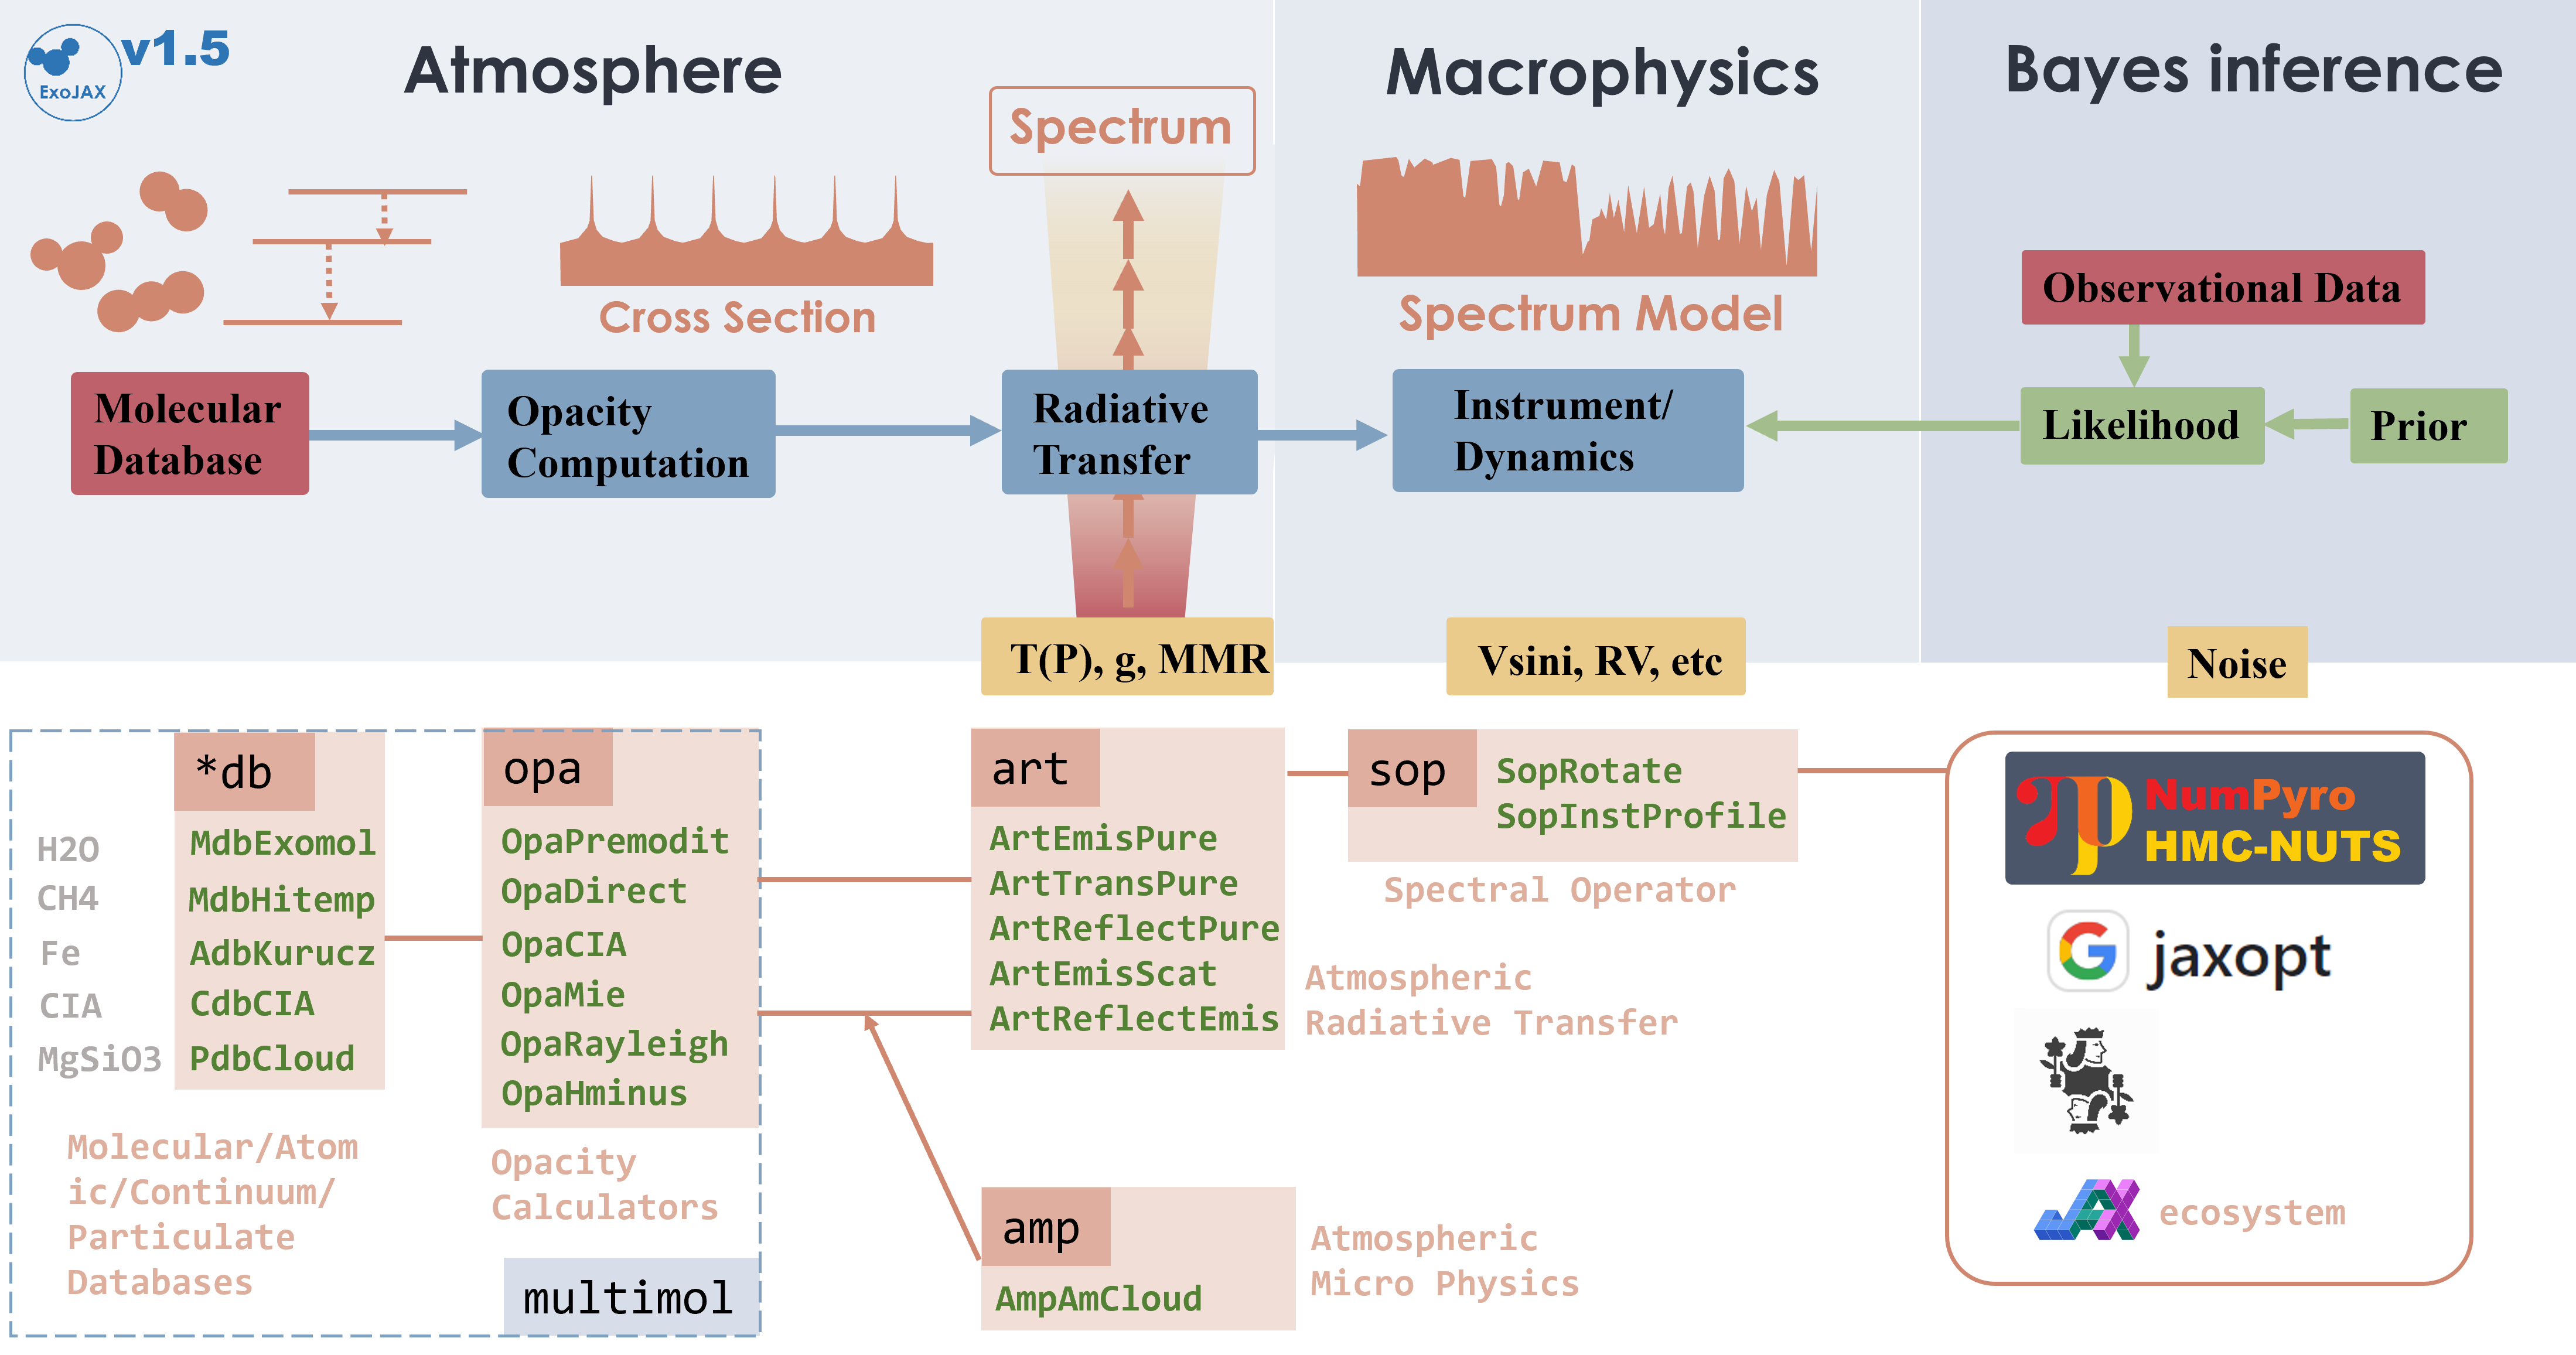

In [2]:
from IPython.display import Image
Image("../exojax.png")

## 1. Defines of Layerwise Opacity Class (OpaLayer)

ExoJAX has various opacity calculator classes, so-called `opa`. Here, we use a memory-saved opa, `OpaPremodit`. We assume the robust tempreature range we will use is 500-1500K.

In [3]:
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.layeropacity import single_layer_optical_depth
from exojax.utils.grids import wavenumber_grid
from exojax.spec.api import MdbExomol
from exojax.utils.astrofunc import gravity_jupiter


class OpaLayer:
    # user defined class, needs to define self.nugrid
    def __init__(self, Nnus=200000):
        self.nu_grid, self.wav, self.resolution = wavenumber_grid(
            1900.0, 2300.0, Nnus, unit="cm-1", xsmode="premodit"
        )
        self.mdb_co = MdbExomol(".database/CO/12C-16O/Li2015", nurange=self.nu_grid)
        self.opa_co = OpaPremodit(
            self.mdb_co,
            self.nu_grid,
            auto_trange=[500.0, 1500.0],
            dit_grid_resolution=1.0,
            allow_32bit=True
        )
        self.gravity = gravity_jupiter(1.0, 10.0)


    def __call__(self, params):
        temperature, pressure, dP, mixing_ratio = params
        xsv_co = self.opa_co.xsvector(temperature, pressure)
        dtau_co = single_layer_optical_depth(
            xsv_co, dP, mixing_ratio, self.mdb_co.molmass, self.gravity
        )
        return dtau_co

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:13: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Do not put  `@partial(jit, static_argnums=(0,))` on ``__call__``.  This is not necessary and makes the code significantly slow.

Call ``OpaLayer`` and set ``OpartEmisPure``.

In [4]:
from exojax.spec.opart import OpartEmisPure

opalayer = OpaLayer(Nnus=200000)
opart = OpartEmisPure(opalayer, pressure_top=1.0e-5, pressure_btm=1.0e1, nlayer=200, nstream=8)
opart.change_temperature_range(400.0, 1500.0)


xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: xsmode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
HITRAN exact name= (12C)(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/exojax/src/radis/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(
/home/kawahara/exojax/src/exojax/spec/opacalc.py:215: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: params automatically set.
default elower grid trange (degt) file version: 2
Robust range: 485.7803992045456 - 1514.171191195336 K
OpaPremodit: Tref_broadening is set to  866.0254037844389 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 0it [00:00, ?it/s]


Premodit: Twt= 1108.7151960064205 K Tref= 570.4914318566549 K
Making LSD:|####################| 100%


Define the layer update function.

In [5]:
def layer_update_function(carry_tauflux, params):
    carry_tauflux = opart.update_layer(carry_tauflux, params)
    return carry_tauflux, None


In [6]:
temperature = opart.clip_temperature(opart.powerlaw_temperature(900.0, 0.1))
mixing_ratio = opart.constant_mmr_profile(0.01)
layer_params = [temperature, opart.pressure, opart.dParr, mixing_ratio]
flux = opart(layer_params, layer_update_function)
        

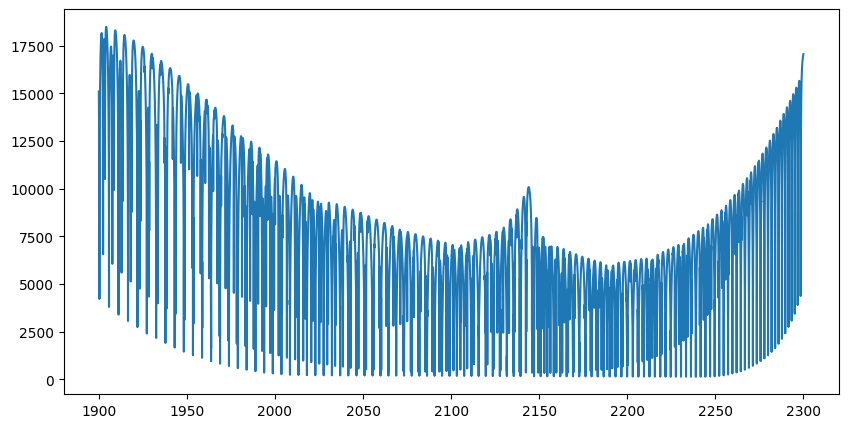

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.plot(opalayer.nu_grid, flux)
plt.show()    